In [37]:
# Import the quantum chemistry driver and related units
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

# Import the qubit mapper library for Ci+ and Ci
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper, BravyiKitaevSuperFastMapper, ParityMapper

# Import a classical analyzer to compare results with VQE
from qiskit_algorithms import NumPyMinimumEigensolver

# Import VQE and related libraries
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, NELDER_MEAD
from qiskit.primitives import Estimator, StatevectorEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

# Import ground state solver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

import numpy as np

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
driver = PySCFDriver(
    atom="H 0.0 0.0 0.0; Li 0.0 0.0 1.596",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

In [30]:
full_problem = driver.run()
fc_transformer = FreezeCoreTransformer()
es_problem = fc_transformer.transform(full_problem)
print(full_problem.num_particles, full_problem.num_spatial_orbitals)
print(es_problem.num_particles, es_problem.num_spatial_orbitals)

(2, 2) 6
(1, 1) 5


In [31]:
mapper = ParityMapper()
print(mapper)

In [32]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)
noiseless_estimator = Estimator()
vqe_solver = VQE(noiseless_estimator, ansatz, SLSQP())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

In [33]:
# ansatz.decompose().draw()

In [34]:
calc = GroundStateEigensolver(mapper, vqe_solver)

In [35]:
%%time
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.87685339225
  - computed part:      -1.078977575993
  - FreezeCoreTransformer extracted energy part: -7.797875816258
~ Nuclear repulsion energy (Hartree): 0.994694005489
> Total ground state energy (Hartree): -7.882159386761
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  9.04800868]
 
  0: 
  * Electronic dipole moment (a.u.): [-0.000000329437  -0.000001530697  7.230303066568]
    - computed part:      [-0.000000329437  -0.000001530697  1.19425133885]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  6.036051727718]
  > Dipole moment (a.u.): [0.000000329437  0.000001530697  1.817705613432]  Total: 1.817705613433
                 (debye): [0.000000837346  0.000003890643  4.620146392108]  Total: 4.62014639211
 
CPU times: user 2min 57s, sys: 983 ms, total: 2min 58s
Wall time: 2min 59s


### Comparing with a classical Eigensolver (provided by numpy)

In [8]:
numpy_solver = NumPyMinimumEigensolver()
calc2 = GroundStateEigensolver(mapper, numpy_solver)

In [9]:
%%time
res2 = calc2.solve(es_problem)
print(res2)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.876853502586
  - computed part:      -1.078977686329
  - FreezeCoreTransformer extracted energy part: -7.797875816258
~ Nuclear repulsion energy (Hartree): 0.994694005489
> Total ground state energy (Hartree): -7.882159497097
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  9.04800868]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  7.229722739363]
    - computed part:      [0.0  0.0  1.193671011645]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  6.036051727718]
  > Dipole moment (a.u.): [0.0  0.0  1.818285940637]  Total: 1.818285940637
                 (debye): [0.0  0.0  4.621621436593]  Total: 4.621621436593
 
CPU times: user 1.92 s, sys: 34.2 ms, total: 1.95 s
Wall time: 1.84 s


### Effect of varying interatomic distance

In [46]:
molecule = "H 0.0 0.0 0.0; Li 0.0 0.0 {}"
delta = 0.05
steps = 20
start = 1.0
energies = np.empty(steps + 1)
hf_energies = np.empty(steps + 1)
np_energies = np.empty(steps + 1)
distances = np.empty(steps + 1)

In [51]:
def run_simulation(dist):
    print("\tMolecule: {}", molecule.format(dist))
    driver = PySCFDriver(
        atom=molecule.format(dist),
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    full_problem = driver.run()
    problem = fc_transformer.transform(full_problem)
    
    return (vqe_simulation(problem), numpy_simulation(problem))

In [52]:
def numpy_simulation(problem):
    numpy_solver = NumPyMinimumEigensolver()
    calc = GroundStateEigensolver(mapper, numpy_solver)
    return calc.solve(problem)

In [53]:
def vqe_simulation(problem):
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )
    
    solver = VQE(Estimator(), ansatz, SLSQP())
    solver.initial_point = [0.0] * ansatz.num_parameters
    calc = GroundStateEigensolver(mapper, vqe_solver)
    return calc.solve(problem)

In [54]:
for step in range(steps + 1):
    dist = start + (delta * step)
    distances[step] = dist       # For later use in plotting
    result1, result2 = run_simulation(dist)
    energies[step] = result1.total_energies
    hf_energies[step] = result1.hartree_fock_energy
    np_energies[step] = result2.total_energies
    print("Iteration: {}; Distance: {}; Energy: {}; Hartee-Fock: {}, NP Energy: {}".format(
        step, dist, energies[step], hf_energies[step], np_energies[step])
    )
    print("=" * 10)

	Molecule: {} H 0.0 0.0 0.0; Li 0.0 0.0 1.0


/var/folders/2n/gz75zbhd50d7m9pgjxyccxch0000gn/T/ipykernel_32481/649587612.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[step] = result1.total_energies
/var/folders/2n/gz75zbhd50d7m9pgjxyccxch0000gn/T/ipykernel_32481/649587612.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  np_energies[step] = result2.total_energies


Iteration: 0; Distance: 1.0; Energy: -7.784021291935523; Hartee-Fock: -7.7673621357485585, NP Energy: -7.784021320448159
	Molecule: {} H 0.0 0.0 0.0; Li 0.0 0.0 1.05
Iteration: 1; Distance: 1.05; Energy: -7.806701998730805; Hartee-Fock: -7.790175295375702, NP Energy: -7.80670202645123
	Molecule: {} H 0.0 0.0 0.0; Li 0.0 0.0 1.1
Iteration: 2; Distance: 1.1; Energy: -7.825202724158871; Hartee-Fock: -7.80874317649341, NP Energy: -7.825202752913148
	Molecule: {} H 0.0 0.0 0.0; Li 0.0 0.0 1.15
Iteration: 3; Distance: 1.15; Energy: -7.840175192159641; Hartee-Fock: -7.823710990035462, NP Energy: -7.840175223766705
	Molecule: {} H 0.0 0.0 0.0; Li 0.0 0.0 1.2
Iteration: 4; Distance: 1.2; Energy: -7.852161224080148; Hartee-Fock: -7.83561582555692, NP Energy: -7.852161260058632
	Molecule: {} H 0.0 0.0 0.0; Li 0.0 0.0 1.25
Iteration: 5; Distance: 1.25; Energy: -7.861611873700326; Hartee-Fock: -7.844905315573969, NP Energy: -7.861611916092716
	Molecule: {} H 0.0 0.0 0.0; Li 0.0 0.0 1.3
Iteration: 6

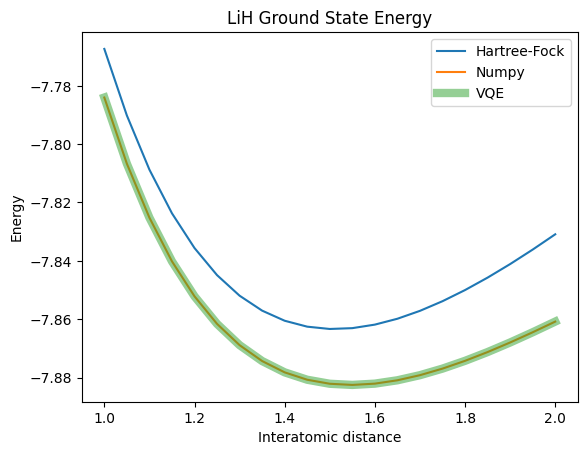

In [55]:
plt.plot(distances, hf_energies, label="Hartree-Fock")
plt.plot(distances, np_energies, label="Numpy")
plt.plot(distances, energies, label="VQE", alpha=0.5, linewidth=6) 
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')
plt.title('LiH Ground State Energy')
plt.legend(loc='upper right')
plt.show()

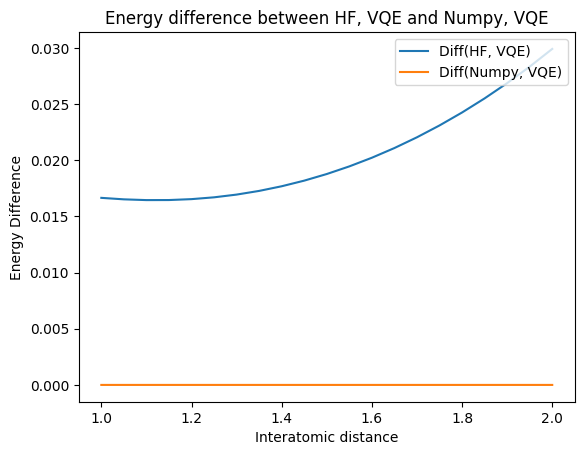

In [56]:
plt.plot(distances, np.subtract(hf_energies, energies), label="Diff(HF, VQE)")
plt.plot(distances, np.subtract(np_energies, energies), label="Diff(Numpy, VQE)")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy Difference")
plt.title("Energy difference between HF, VQE and Numpy, VQE")
plt.legend(loc="upper right")
plt.show()